<a href="https://colab.research.google.com/github/hderoche/RNN_Bitcoin_Prediction/blob/master/StatistiquesDescriptivesBTC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Statistiques descriptives sur l'historique du Bitcoin**

---
1.   Mesure de volatilité
2.   Corrélation volatilité / volume échangé
3.   Pourcentage par unité de temps
4.   Moyennes mobiles (exponentielles)
5.   Variances et écart-types

---

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

### Importer les données

In [32]:
# dataBtc = pd.read_csv('data_btc.csv', header=0)
# dataBTC = pd.read_csv('price_btc_1h.csv', header=0, sep=',')
#dataBitstamp = pd.read_csv('Bitstamp_BTCUSD_1h.csv', header=0, sep=';')
dataBitstamp = pd.read_csv('Bitstamp_BTCUSD_d.csv', header=0, sep=';')
# This dataset has a column of Timstamp
print('Nom des colonnes :',dataBitstamp.columns)

### Drop du timestamp
#dataBitstamp = dataBitstamp.drop(['Unix Timestamp'], axis=1)
dataBitstamp = dataBitstamp.drop(['unix'], axis=1)


# Data processing and slicing dataframe in order to have the right dimension to input in the RNN
data = pd.DataFrame(dataBitstamp, index=[i for i in range(dataBitstamp.shape[0])])
# The datafiles I had were reversed, meaning that the index of the lastest data was 0, so I had to reverse the dataframe
data = data[::-1]
#data = data.drop(['Date','Symbol', 'Volume USD'], axis=1)
data = data.drop(['date','symbol'], axis=1)
print(data.shape)
print(data.head())


Nom des colonnes : Index(['unix', 'date', 'symbol', 'open', 'high', 'low', 'close', 'Volume BTC',
       'Volume USD'],
      dtype='object')
(2221, 6)
        open    high     low   close  Volume BTC  Volume USD
2220  363.59  381.34  360.57  376.28  3220878.18     8617.15
2219  376.42  386.60  372.25  376.72  2746157.05     7245.19
2218  376.57  381.99  373.32  373.34  1145566.61     3046.33
2217  376.40  382.31  373.03  378.39  2520662.37     6660.56
2216  378.39  382.86  375.23  379.25  2593576.46     6832.53


### Indicateurs

In [33]:
def moving_average(data, param):
  data['MA' + str(param)] = data.iloc[:,3].rolling(window=param).mean()
  data = data[::-1]
  return data

def exponential_moving_average(data, param):
  data['EMA' + str(param)] = data.iloc[:, 3].ewm(span=param).mean()
  data = data[::-1]
  return data

print(moving_average(data, 200))
print(exponential_moving_average(data, 13)['EMA13'])

          open      high       low  ...    Volume BTC    Volume USD        MA200
0     24714.01  24768.79  24532.28  ...  6.601946e+01  1.625054e+06  12922.98545
1     23747.22  24777.00  23403.82  ...  6.469229e+03  1.598233e+08  12848.79580
2     23215.00  23779.14  22700.10  ...  7.185482e+03  1.704848e+08  12774.18505
3     23819.08  24096.90  22624.92  ...  1.154197e+04  2.683244e+08  12704.30385
4     22750.07  23843.21  22383.59  ...  9.367609e+03  2.232779e+08  12636.41455
...        ...       ...       ...  ...           ...           ...          ...
2216    378.39    382.86    375.23  ...  2.593576e+06  6.832530e+03          NaN
2217    376.40    382.31    373.03  ...  2.520662e+06  6.660560e+03          NaN
2218    376.57    381.99    373.32  ...  1.145567e+06  3.046330e+03          NaN
2219    376.42    386.60    372.25  ...  2.746157e+06  7.245190e+03          NaN
2220    363.59    381.34    360.57  ...  3.220878e+06  8.617150e+03          NaN

[2221 rows x 7 columns]
0  

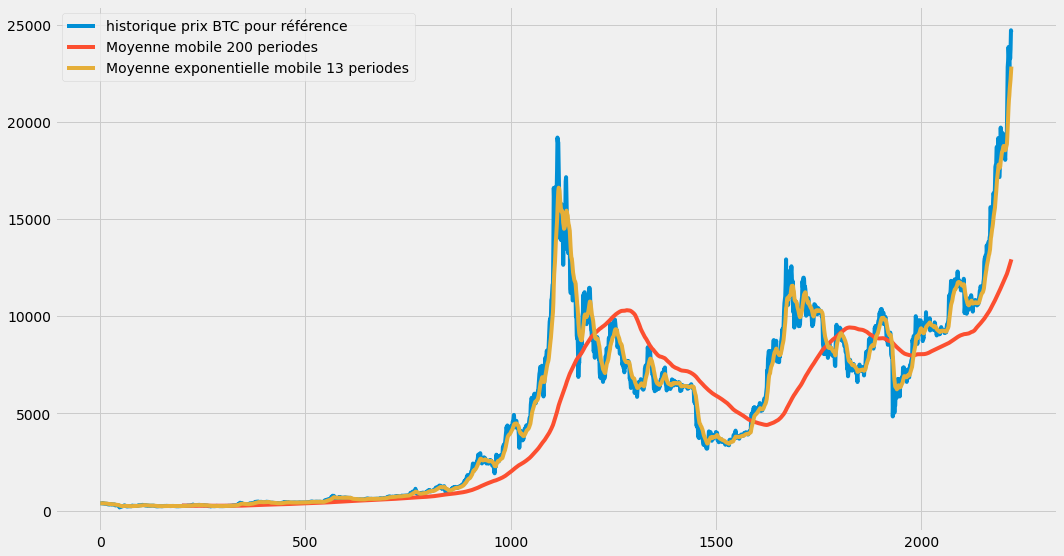

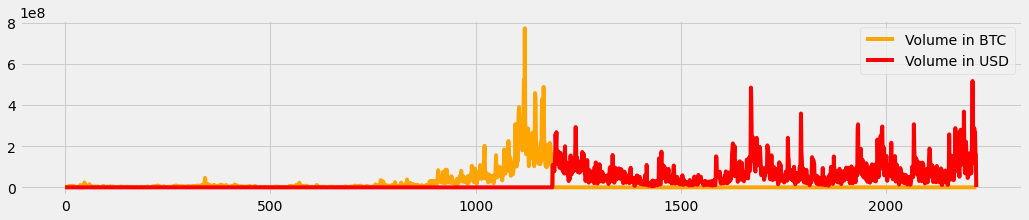

In [35]:
plt.figure(figsize=[16,9])
dataTemp = data.reset_index()
plt.plot(dataTemp['close'], label='historique prix BTC pour référence')
plt.plot(dataTemp['MA200'], label="Moyenne mobile 200 periodes")
plt.plot(dataTemp['EMA13'], label='Moyenne exponentielle mobile 13 periodes')
plt.legend()
plt.figure(figsize=[16,3])
plt.plot(dataTemp['Volume BTC'], color="orange", scaley='log', label="Volume in BTC")
plt.plot(dataTemp['Volume USD'], color="red", scaley='log', label="Volume in USD")
plt.legend()
plt.show()

Sur ces graphiques on peut voir que les moyennes mobiles permettent éventuellement d'avoir de l'information sur un changement de tendance.

Si la moyenne mobile se trouve au dessus du cours alors la tendance est à la vente

Dans le cas contraire, la tendance est à l'achat.

En se basant sur ces informations on peut par exemple scorer avec des règles préécrites pour que le robot puisse soit acheter soit vendre si un nombre suffisant de règles sont validées

### Volatilité et Volume (Correlation)

In [23]:
def volatility_max():
  data['vol'] = data['high'].sub(data['low'], axis=0)
  print(data.head())
volatility_max()

        open    high     low   close  Volume BTC  MA200       EMA13    vol
2220  363.59  381.34  360.57  376.28  3220878.18    NaN  376.280000  20.77
2219  376.42  386.60  372.25  376.72  2746157.05    NaN  376.516923  14.35
2218  376.57  381.99  373.32  373.34  1145566.61    NaN  375.291181   8.67
2217  376.40  382.31  373.03  378.39  2520662.37    NaN  376.253077   9.28
2216  378.39  382.86  375.23  379.25  2593576.46    NaN  377.049845   7.63


In [24]:
# Pre-processing for display
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

dataN = normalize(data)
dfCorrelationN = pd.DataFrame()
dfCorrelationN['volumeBTC'] = dataN['Volume BTC']
dfCorrelationN['volatility'] = dataN['vol']
print(dfCorrelationN.head())
print(dfCorrelationN.corr())

      volumeBTC  volatility
2220   0.004170    0.004480
2219   0.003556    0.003096
2218   0.001483    0.001870
2217   0.003264    0.002002
2216   0.003358    0.001646
            volumeBTC  volatility
volumeBTC    1.000000    0.612587
volatility   0.612587    1.000000


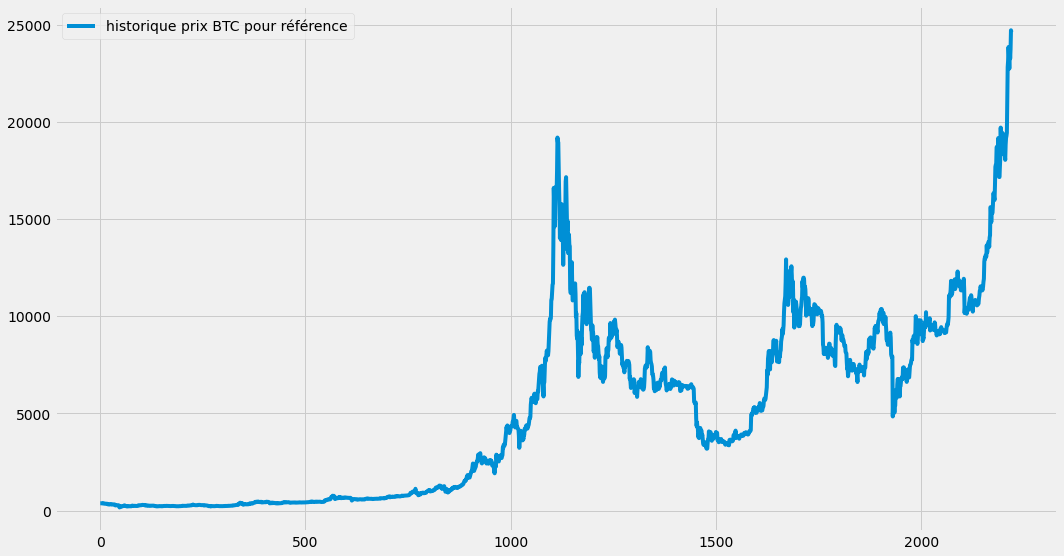

In [36]:
plt.figure(figsize=[16,9])
dataTemp = data.reset_index()
plt.plot(dataTemp['close'], label='historique prix BTC pour référence')
plt.legend()


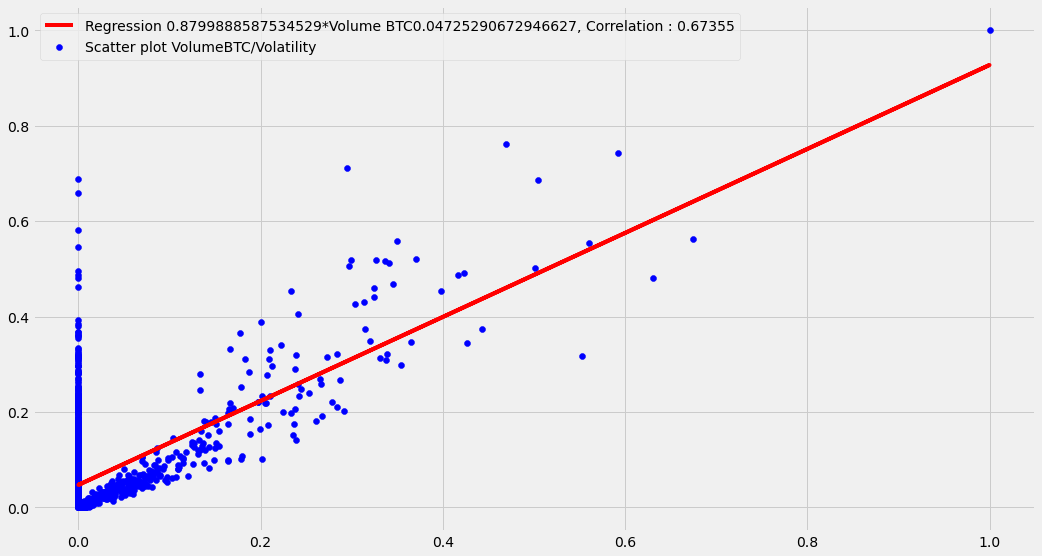

In [26]:
plt.figure(figsize=[16,9])
plt.scatter(dfCorrelationN['volumeBTC'], dfCorrelationN['volatility'], color='blue', label='Scatter plot VolumeBTC/Volatility')
m, b = np.polyfit(dfCorrelationN['volumeBTC'], dfCorrelationN['volatility'], 1)
plt.plot(dfCorrelationN['volumeBTC'], m*dfCorrelationN['volumeBTC'] + b, color='red', label='Regression ' + str(m) + '*Volume BTC'+ str(b) + ', Correlation : 0.67355')
plt.legend()
plt.show()

          open      high       low  ...  MA200     EMA13       vol
2220  0.008211  0.006860  0.008539  ...    NaN  0.006690  0.004480
2219  0.008733  0.007074  0.009018  ...    NaN  0.006701  0.003096
2218  0.008739  0.006886  0.009062  ...    NaN  0.006647  0.001870
2217  0.008732  0.006899  0.009050  ...    NaN  0.006689  0.002002
2216  0.008814  0.006921  0.009140  ...    NaN  0.006724  0.001646

[5 rows x 8 columns]
   index      open      high  ...     MA200     EMA13       vol
0      0  1.000000  0.999666  ...  1.000000  1.000000  0.051019
1      1  0.960623  1.000000  ...  0.994148  0.986910  0.296220
2      2  0.938946  0.959377  ...  0.988263  0.970972  0.232768
3      3  0.963550  0.972313  ...  0.982750  0.959592  0.317533
4      4  0.920009  0.961986  ...  0.977395  0.949843  0.314866

[5 rows x 9 columns]


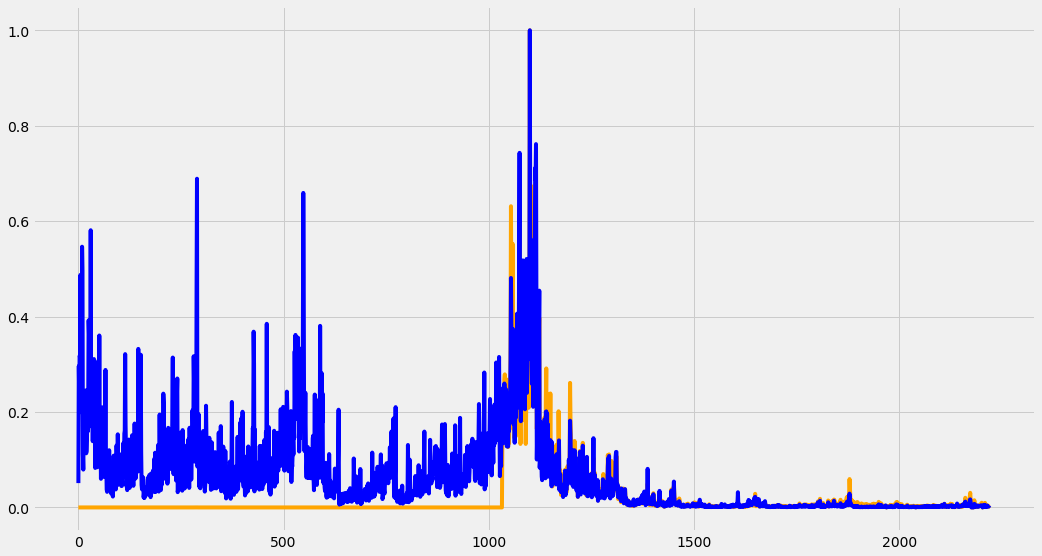

In [27]:
# removing noisy data

print(dataN.head())
dataN = dataN[::-1].reset_index()
print(dataN.head())
plt.figure(figsize=[16,9])
plt.plot(dataN['Volume BTC'], color='orange')
plt.plot(dataN['vol'], color='blue')
plt.plot()
plt.show()

### Moyenne des pourcentages volatilité

In [28]:
# Nomalisation

data['diff'] = data['close'] - data['open']
data['per'] = ( data['diff']*100 )/data['open']
dataNorm = normalize(data)
print(data.head())
print(dataNorm.head())
meanVolatilityPercentage = data['per'].mean()
minVolatilityPercentage = data['per'].min()
maxVolatilityPercentage = data['per'].max()
print('mean',meanVolatilityPercentage)
print('max',maxVolatilityPercentage)
print('min',minVolatilityPercentage)

        open    high     low   close  ...       EMA13    vol   diff       per
2220  363.59  381.34  360.57  376.28  ...  376.280000  20.77  12.69  3.490195
2219  376.42  386.60  372.25  376.72  ...  376.516923  14.35   0.30  0.079698
2218  376.57  381.99  373.32  373.34  ...  375.291181   8.67  -3.23 -0.857742
2217  376.40  382.31  373.03  378.39  ...  376.253077   9.28   1.99  0.528693
2216  378.39  382.86  375.23  379.25  ...  377.049845   7.63   0.86  0.227279

[5 rows x 10 columns]
          open      high       low  ...       vol      diff       per
2220  0.008211  0.006860  0.008539  ...  0.004480  0.513422  0.626628
2219  0.008733  0.007074  0.009018  ...  0.003096  0.511388  0.576504
2218  0.008739  0.006886  0.009062  ...  0.001870  0.510808  0.562727
2217  0.008732  0.006899  0.009050  ...  0.002002  0.511665  0.583103
2216  0.008814  0.006921  0.009140  ...  0.001646  0.511480  0.578673

[5 rows x 10 columns]
mean 0.26124685072043163
max 28.895061728395063
min -39.1466374403